In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
sys.path.append("..")

In [6]:
from util import show, plot_images, plot_tensors

In [7]:
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from skimage.measure import compare_psnr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()

])
train_data = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(
    root=GT_DATA_PATH, transform=TRANSFORM_IMG)

dataset1 = train_data
dataset2 = gt_data

In [8]:
class gtmatch():
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y = self.dataset2[int(index / batch_size % batch_size)][0]
        return x, y

    def __len__(self):
        return len(self.dataset1)


newdataset = gtmatch(dataset1, dataset2, 50)

In [9]:
from torch import randn
batch_size = 50


def add_noise(img):
    poisson=torch.distributions.poisson.Poisson(img.detach())
    noise=poisson.sample()
    return img.detach()+noise*.5

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]
        gt = self.data[index][1]

        return add_noise(img), img, gt

In [10]:
newdataset = SyntheticNoiseDataset(newdataset, 'train')


In [11]:
from models.RIM_v2 import RIM

In [12]:
model = RIM()

In [13]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import logging
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [14]:
from torch.utils.data.sampler import SequentialSampler
validation_split = .2
random_seed = 42
shuffle_dataset = False

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)


train_loader = torch.utils.data.DataLoader(
    newdataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## RIM

In [12]:
data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_val_loss = 1
st1=0
st2=-0

for i, batch in enumerate(data_loader):

    noisy_images, clean_images, gt = batch

    model.train()

    net_input = noisy_images

    net_output, st1, st2 = model(net_input, st1, st2, i)

    loss = loss_function(net_output, noisy_images)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    losses.append(loss.item())
    model.eval()

    val_loss = loss_function(net_output, noisy_images)

    val_losses.append(val_loss.item())

    print("Loss (", i, "): \t", round(loss.item(), 4))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = noisy_images*model(noisy_images, st1, st2, i)[0].detach()
        net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
        denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        clean_comp = clean_images.detach().cpu().numpy()[
            0, 0].astype(np.float64)
        best_psnr = compare_psnr(clean_comp, denoised_arr)
        noisy_input.append(net_input_np)
        best_images.append(denoised_arr)
        clean_image_corr.append(clean_images)
        print("\tModel PSNR: ", np.round(best_psnr, 2))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss ( 0 ): 	 0.1001


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  26.23
Loss ( 1 ): 	 0.1311
Loss ( 2 ): 	 0.1312
Loss ( 3 ): 	 0.1015
Loss ( 4 ): 	 0.1301
Loss ( 5 ): 	 0.1329
Loss ( 6 ): 	 0.138
Loss ( 7 ): 	 0.1315
Loss ( 8 ): 	 0.1057
Loss ( 9 ): 	 0.0883
	Model PSNR:  24.5
Loss ( 10 ): 	 0.127
Loss ( 11 ): 	 0.1035
Loss ( 12 ): 	 0.1157
Loss ( 13 ): 	 0.129
Loss ( 14 ): 	 0.1428
Loss ( 15 ): 	 0.1221


In [13]:
model_output = []
Input_PSNR = []
Model_PSNR = []

model_output = []
Input_PSNR = []
Model_PSNR = []
Model_loss = []
clipped_model_loss = []


for i, batch in enumerate(validation_loader):

    noisy_images, clean_images, gt = batch

    model.eval()

    net_input = noisy_images

    denoised = noisy_images+model(noisy_images, st1, st2, i)[0].detach()
    denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    model_output.append([torch.from_numpy(clean_comp),torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), gt])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))

    Model_loss.append(loss_function(denoised, noisy_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), noisy_images))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.m

Input PSNR =  18.74
Simple RIM PSNR =  21.8748

Simple RIM Loss =  tensor(0.0474)
Clipped Simple RIM Loss =  tensor(0.0234, dtype=torch.float64)


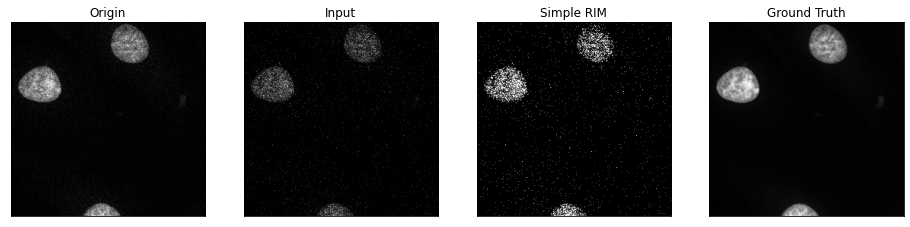

In [14]:
idx=2
plot_tensors(model_output[idx], ["Origin","Input", "Simple RIM","Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))

In [15]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))

Average Input PSNR =  19.76
Average Simple RIM PSNR =  22.6438

Average Simple RIM Loss =  0.0495
Average Clipped Simple RIM Loss =  0.0184


## RIM with J-Invariant Mask

In [15]:
from mask_RIM_v2 import Masker
masker = Masker(width=4, mode='interpolate')

data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_Jimages = []
best_val_loss = 1
st1=0
st2=0

for i, batch in enumerate(data_loader):
    noisy_images, clean_images, gt = batch

    model.train()

    net_input, mask = masker.mask(noisy_images, i % (masker.n_masks - 1))
    

    net_output, st1, st2 = model(net_input, st1, st2, i)

    loss = loss_function(net_output*mask, noisy_images*mask)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    losses.append(loss.item())

    model.eval()
    val_loss = loss_function(net_output*mask, noisy_images*mask)
    val_losses.append(val_loss.item())

    print("Loss (", i, "): \t", round(loss.item(), 4))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = noisy_images*model(noisy_images, st1, st2, i)[0].detach()
        Jinv = noisy_images * \
            masker.infer_full_image(noisy_images, model, st1, st2, i)[0].detach()
        Jinv = np.clip(-Jinv, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
        denoised_arr = np.clip(denoised, 0, 1).cpu().numpy()[
            0, 0].astype(np.float64)
        clean_comp = clean_images.detach().cpu().numpy()[
            0, 0].astype(np.float64)

        best_psnr = compare_psnr(clean_comp, Jinv)

        noisy_input.append(net_input_np)
        best_images.append(denoised_arr)
        best_Jimages.append(Jinv)
        clean_image_corr.append(clean_images)
        print("\tModel PSNR: ", np.round(best_psnr, 2))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss ( 0 ): 	 0.0027


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  27.85
Loss ( 1 ): 	 0.0043
Loss ( 2 ): 	 0.0042
Loss ( 3 ): 	 0.0026
	Model PSNR:  25.93
Loss ( 4 ): 	 0.0039
Loss ( 5 ): 	 0.0041
Loss ( 6 ): 	 0.0043
Loss ( 7 ): 	 0.0038
Loss ( 8 ): 	 0.0027
Loss ( 9 ): 	 0.0018
	Model PSNR:  25.64
Loss ( 10 ): 	 0.0036
Loss ( 11 ): 	 0.0026
Loss ( 12 ): 	 0.0031
Loss ( 13 ): 	 0.0037
Loss ( 14 ): 	 0.0042
Loss ( 15 ): 	 0.0034


In [20]:
model_output = []
Input_PSNR = []
Model_PSNR = []
JInv_PSNR = []
Model_loss = []
clipped_model_loss = []

JInv_loss = []
clipped_JInv_loss = []

for i, batch in enumerate(validation_loader):

    noisy_images, clean_images, gt = batch

    model.eval()

    net_input = noisy_images

    denoised = noisy_images*model(noisy_images, st1, st2, i)[0].detach()
    denoised_arr = np.clip(-denoised, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)
    Jinv = noisy_images * \
        masker.infer_full_image(noisy_images, model, st1, st2, i)[0].detach()
    Jinv_np = np.clip(-Jinv, 0, 1).cpu().numpy()[
        0, 0].astype(np.float64)

    net_input_np = noisy_images.cpu().numpy()[0, 0].astype(np.float64)
    clean_comp = clean_images.detach().cpu().numpy()[
        0, 0].astype(np.float64)

    model_output.append([torch.from_numpy(clean_comp),torch.from_numpy(net_input_np), torch.from_numpy(
        denoised_arr), torch.from_numpy(Jinv_np), gt])
    Input_PSNR.append(compare_psnr(clean_comp, net_input_np))
    Model_PSNR.append(compare_psnr(clean_comp, denoised_arr))
    JInv_PSNR.append(compare_psnr(clean_comp, Jinv_np))
    
    Model_loss.append(loss_function(denoised, noisy_images))
    clipped_model_loss.append(loss_function(
        torch.from_numpy(denoised_arr), noisy_images))
    
    JInv_loss.append(loss_function(Jinv, noisy_images))
    clipped_JInv_loss.append(loss_function(
        torch.from_numpy(Jinv_np), noisy_images))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/w

Input PSNR =  18.61
Simple RIM PSNR =  20.4516
J-Invariant RIM PSNR =  20.4909

Simple RIM Loss =  tensor(0.0384)
Clipped Simple RIM Loss =  tensor(0.0312, dtype=torch.float64)

J-Invariant RIM Loss =  tensor(0.0386)
Clipped J-Invariant RIM Loss =  tensor(0.0311, dtype=torch.float64)


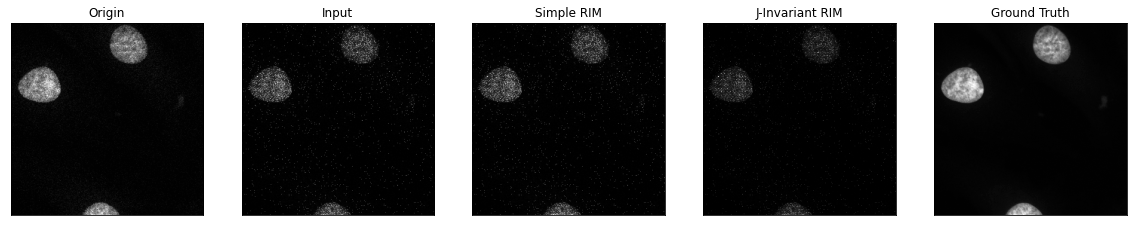

In [24]:
idx=2
plot_tensors(model_output[idx], ["Origin","Input", "Simple RIM",
                               "J-Invariant RIM", "Ground Truth"])
print("Input PSNR = ", np.round(Input_PSNR[idx], 2))
print("Simple RIM PSNR = ", np.round(Model_PSNR[idx], 4))
print("J-Invariant RIM PSNR = ", np.round(JInv_PSNR[idx], 4))
print("")
print("Simple RIM Loss = ", np.round(Model_loss[idx], 4))
print("Clipped Simple RIM Loss = ", np.round(clipped_model_loss[idx], 4))
print("")
print("J-Invariant RIM Loss = ", np.round(JInv_loss[idx], 4))
print("Clipped J-Invariant RIM Loss = ", np.round(clipped_JInv_loss[idx], 4))

In [23]:
print("Average Input PSNR = ", np.round(np.mean(Input_PSNR), 2))
print("Average Simple RIM PSNR = ", np.round(np.mean(Model_PSNR), 4))
print("Average J-Invariant RIM PSNR = ", np.round(np.mean(JInv_PSNR), 4))
print("")
print("Average Simple RIM Loss = ", np.round(np.mean(Model_loss), 4))
print("Average Clipped Simple RIM Loss = ", np.round(np.mean(clipped_model_loss), 4))
print("")
print("Average J-Invariant RIM Loss = ", np.round(np.mean(JInv_loss), 4))
print("Average Clipped J-Invariant RIM Loss = ", np.round(np.mean(clipped_JInv_loss), 4))

Average Input PSNR =  19.78
Average Simple RIM PSNR =  23.6134
Average J-Invariant RIM PSNR =  23.5006

Average Simple RIM Loss =  0.0272
Average Clipped Simple RIM Loss =  0.0219

Average J-Invariant RIM Loss =  0.027
Average Clipped J-Invariant RIM Loss =  0.022
